In this notebook we demonstrate usages of the two moduldes `rep_drift` and `visualize_drift`.

-------
### Similarity analysis and PCA

In [64]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE


from sklearn import datasets, linear_model
from scipy.stats import linregress

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info

import pprint

In [2]:
# import our own functions
import rep_drift, visualize_drift

In [3]:
boc = BrainObservatoryCache()

In [73]:
# use one example container:
data_sets, ordered_days = rep_drift.get_datasets(boc, 540993888) #  540993888 571137444 555040113

In [74]:
# get just one experiment session:
cell_ids_one_session, dff_vals_one_session, run_vals_one_session = rep_drift.get_response_vals(data_sets[0])

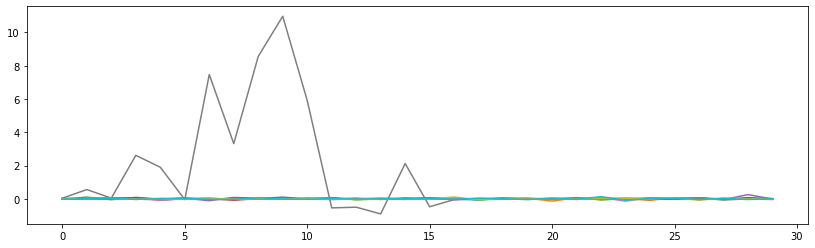

In [75]:
def plot_run(run_vals):
    plt.figure(figsize=(14,4))
    for i in range(10):
        plt.plot(run_vals[i,:])
    
plot_run(run_vals_one_session)

In [76]:
# only one mean is > 1
pprint.pprint(run_vals_one_session.mean(axis = 1)) 

array([ 2.60559430e-03, -2.00794543e-03,  3.33094667e-03, -2.00492254e-03,
        9.31094171e-03, -2.49069741e-03, -2.24707606e-03,  1.36549140e+00,
        3.61292508e-03, -1.02129809e-04])


In [77]:
# get crrelation matrix and angle matrix:
corrs_s, angles_s = rep_drift.calc_similarity(dff_vals_one_session)

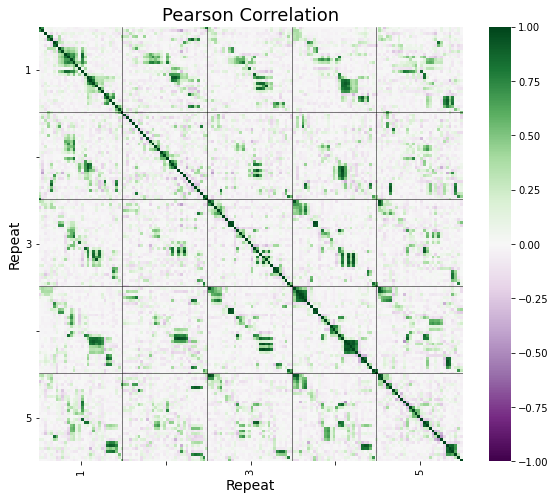

In [78]:
# plot correation, n_repeat_plot can take 10 or 5:
visualize_drift.plot_corr(corrs_s, n_repeat_plot= 5)

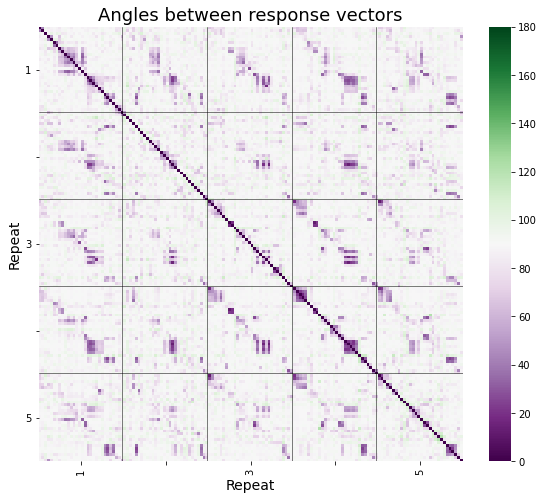

In [104]:
visualize_drift.plot_angle(angles_s, n_repeat_plot= 5)

In [79]:
def plot_2D(Xt, label):
    plt.figure(figsize=(8,6.5))
    plt.scatter(Xt[:,0], Xt[:,1], c= label)
    plt.colorbar()
    plt.show() 

def plot_3D(Xt, label):
    fig = plt.figure(figsize = [8,8])
    ax = fig.add_subplot(projection='3d')
    ax.scatter(Xt[:,0], Xt[:,1], Xt[:,2], c= label)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

In [80]:
dff_vals_s_long = np.reshape(dff_vals_one_session, (300, dff_vals_one_session.shape[-1]))
run_vals_s_long = np.reshape(run_vals_one_session, 300)

In [81]:
label_stimuli = list(range(30))*10

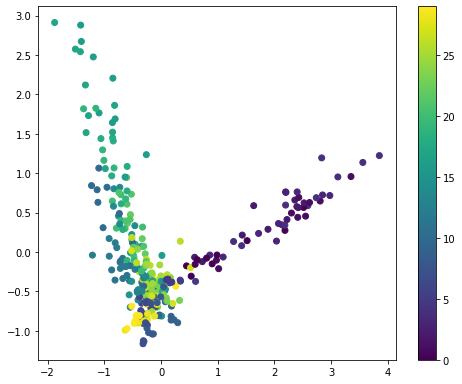

In [82]:
pca = PCA()
Xt_pca = pca.fit_transform(corrs_s)
plot_2D(Xt_pca, label = label_stimuli)

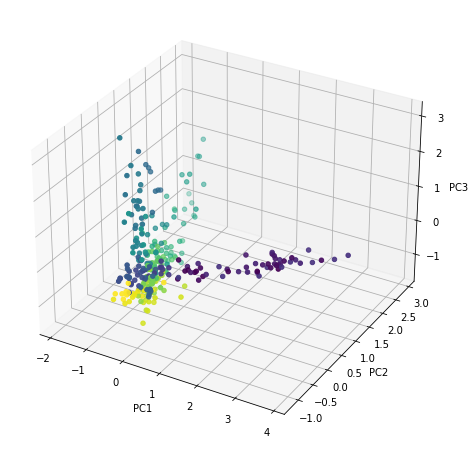

In [83]:
plot_3D(Xt_pca, label = label_stimuli)

2-D geometry almost always spherial for nMDS:

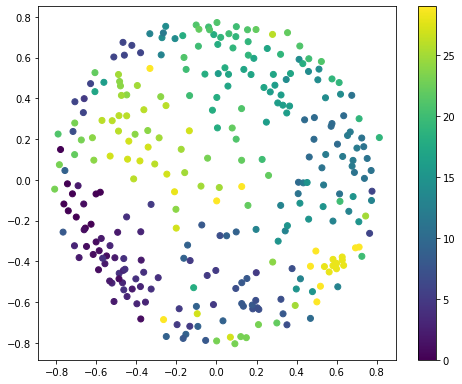

In [84]:
nmds = MDS(random_state= 1693, dissimilarity='precomputed')
Xt_mds =  nmds.fit_transform(1- corrs_s)
plot_2D(Xt_mds, label = label_stimuli)

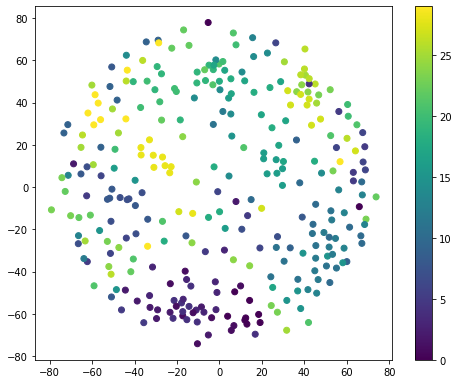

In [85]:
nmds_angle = MDS(random_state= 1693, dissimilarity='precomputed')
Xt_mds_angle =  nmds_angle.fit_transform(angles_s)
plot_2D(Xt_mds_angle, label = label_stimuli)

tSNE keeps the clusters better:

/Users/xinzheng/opt/anaconda3/envs/rep-drift/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/xinzheng/opt/anaconda3/envs/rep-drift/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


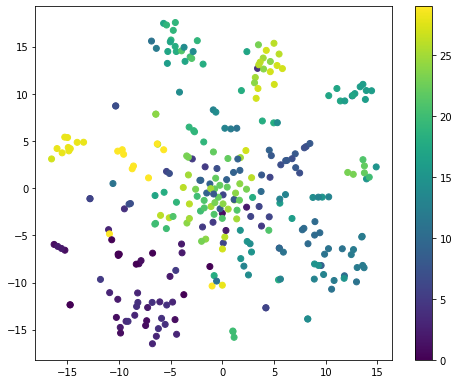

In [86]:
tsne = TSNE(n_components=2)
Xtsne = tsne.fit_transform(dff_vals_s_long)
plot_2D(Xtsne, label = label_stimuli)

-------

### All three experiments:

In [87]:
# get response vectors of all three sessions, align the shared neurons:
dff_vals_container, run_vals_container = rep_drift.align_response_vals(data_sets)

In [90]:
n_sessions = 3
n_repeats = 10
dff_vals_all = np.zeros((30, 30, dff_vals_container[0].shape[-1]))

for session_idx in range(n_sessions):
    dff_vals_all[session_idx*n_repeats:session_idx*n_repeats+n_repeats] = dff_vals_container[session_idx]

In [98]:
def calc_similarity(dff_vals):
    
    n_repeats = 30
    n_divs = 30 

    within_session_corrs = np.zeros((n_repeats*n_divs, n_repeats*n_divs))
    within_session_angles = np.zeros((n_repeats*n_divs, n_repeats*n_divs))

    for repeat_idx1 in range(n_repeats):
        for repeat_idx2 in range(n_repeats):
            # corrcoef for all blocks in repeat_1 and repeat_2:
            within_session_corrs[ 
                repeat_idx1*n_divs : (repeat_idx1+1)*n_divs, 
                repeat_idx2*n_divs : (repeat_idx2+1)*n_divs] = np.corrcoef(
                    # return 30x30 R-values:
                    dff_vals[repeat_idx1], dff_vals[repeat_idx2])[n_divs:, :n_divs] # for some reason corrcoef returns 4 copies of this matrix
            
            for div_idx1 in range(n_divs):
                for div_idx2 in range(n_divs):
                    # calculate angle 
                    # for resp_vec of block_1 in repeat_1 and
                    #  resp_vec in block_2 in repeat_2:
                    within_session_angles[
                        repeat_idx1 * n_divs + div_idx1, 
                        repeat_idx2 * n_divs + div_idx2] = rep_drift.get_align_angle(
                            dff_vals[repeat_idx1, div_idx1], 
                            dff_vals[repeat_idx2, div_idx2])

    return within_session_corrs, within_session_angles

In [99]:
corrs_all, angles_all = calc_similarity(dff_vals_all)

In [100]:
corrs_all.shape

(900, 900)

In [101]:
label_stimuli_all = list(range(30))*30

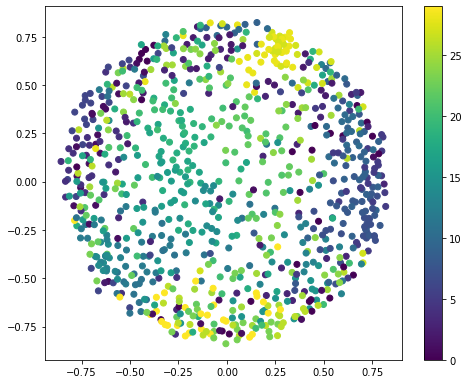

In [112]:
nmds_all = MDS(random_state= 1693, dissimilarity='precomputed')
Xt_mds_all =  nmds_all.fit_transform(1- corrs_all)
plot_2D(Xt_mds_all, label = label_stimuli_all)

In [105]:
# calculate cross session similarities over the mean resp. vectors:
across_session_corrs, across_session_angles =  rep_drift.calc_cross_similarity(dff_vals_container)

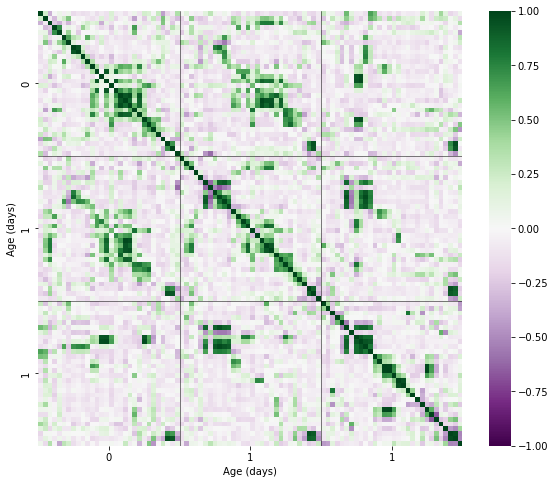

In [106]:
# plot cross session:
visualize_drift.plot_cross_corr(across_session_corrs, ordered_days)

In [108]:
label_stimuli = list(range(30))*3
label_days = [0]*30 + [1]*30 + [2]*30
marker_days = ['o']*30 + ['v']*30 + ['s']*30

#### The topological relationship for different stimuli stays similar for different sessions. But there might be drift cross sessions? (rotations?)

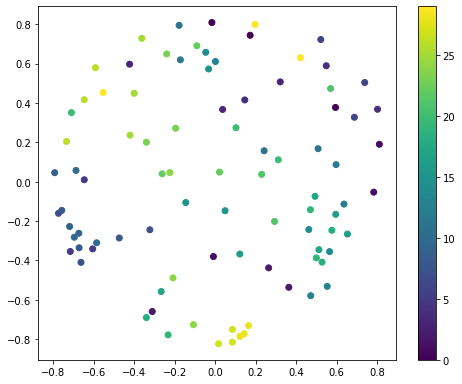

In [110]:
# over mean response vector:
mds_mean = MDS(random_state= 1693, dissimilarity='precomputed')
Xt_mds_mean =  mds_mean.fit_transform(1- across_session_corrs)
plot_2D(Xt_mds_mean, label = label_stimuli)

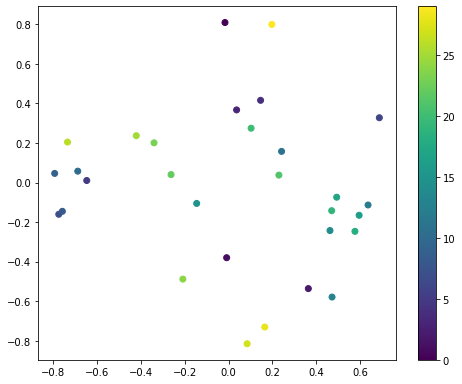

In [115]:
plot_2D(Xt_mds_mean[:30], label = label_stimuli[:30])  # session 1

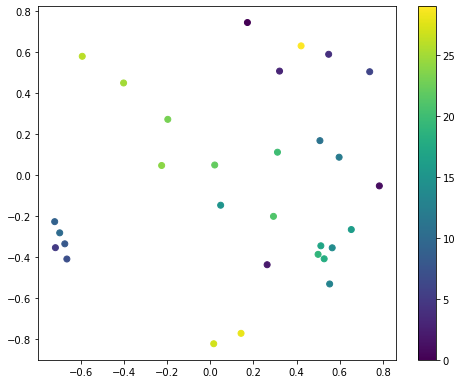

In [116]:
plot_2D(Xt_mds_mean[30:60], label = label_stimuli[:30]) # session 2

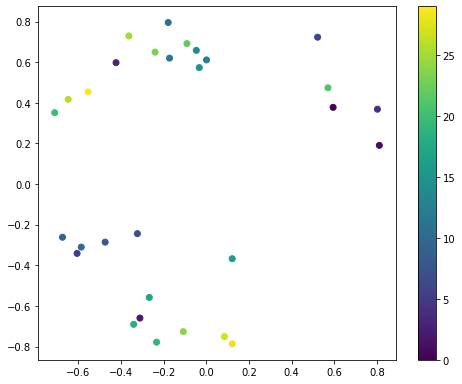

In [117]:
plot_2D(Xt_mds_mean[60:90], label = label_stimuli[:30]) # session 3

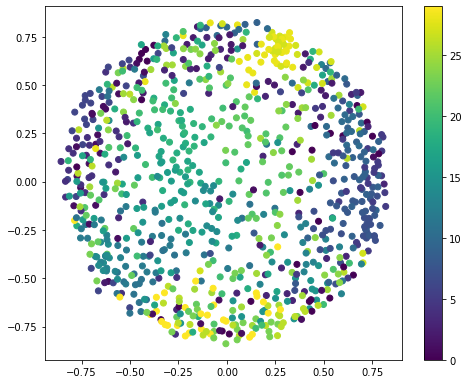

In [118]:
# over all response vectors 
plot_2D(Xt_mds_all, label = label_stimuli_all)

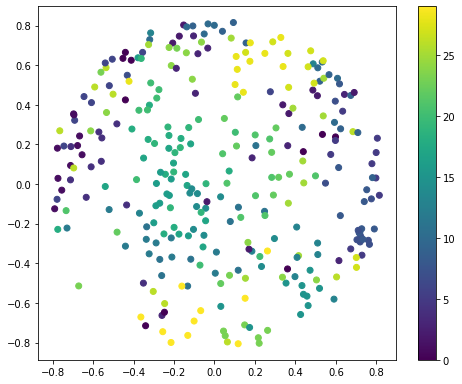

In [119]:
plot_2D(Xt_mds_all[:300], label = label_stimuli_all[:300]) # session 1

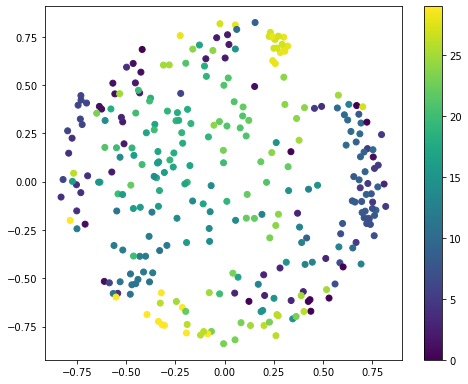

In [120]:
plot_2D(Xt_mds_all[300:600], label = label_stimuli_all[300:600]) # session 2

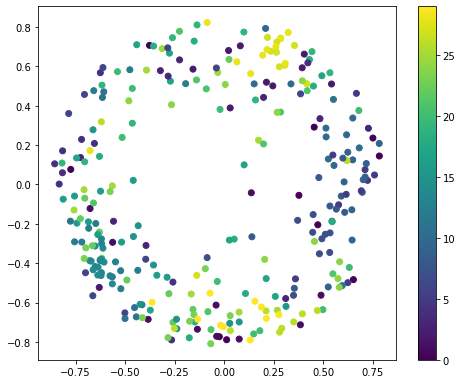

In [121]:
plot_2D(Xt_mds_all[600:900], label = label_stimuli_all[600:900]) # session 3